In [1]:
# Cell 1 - Install required packages (run in Colab if needed)
!pip install -q nltk wordcloud scikit-learn xgboost lightgbm tensorflow


In [2]:
# Cell 2 - Imports and downloads
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# optional models
try:
    from xgboost import XGBClassifier
    has_xgb = True
except Exception:
    has_xgb = False
try:
    import lightgbm as lgb
    has_lgb = True
except Exception:
    has_lgb = False

# text processing
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# wordcloud
from wordcloud import WordCloud

# Keras
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# reproducibility
RSEED = 42
random.seed(RSEED)
np.random.seed(RSEED)
tf.random.set_seed(RSEED)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
df = pd.read_csv("/content/train.csv")
# Inspect
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (120000, 3)


,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [4]:
df['Class Index'].unique()

array([3, 4, 2, 1])

In [5]:
# Combine Title + Description into one text column
df["text"] = df["Title"].fillna('') + ". " + df["Description"].fillna('')

# Use Class Index as the label (numeric)
df["label"] = df["Class Index"]

# Keep only relevant columns
df = df[["text", "label"]]

print("Final dataset shape:", df.shape)
print(df["label"].value_counts())
df.head()


Final dataset shape: (120000, 2)
label
3    30000
4    30000
2    30000
1    30000
Name: count, dtype: int64


,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,3
1,Carlyle Looks Toward Commercial Aerospace (Reu...,3
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,3
3,Iraq Halts Oil Exports from Main Southern Pipe...,3
4,"Oil prices soar to all-time record, posing new...",3


In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["label"] = le.fit_transform(df["label"])  # will become 0,1,2,3


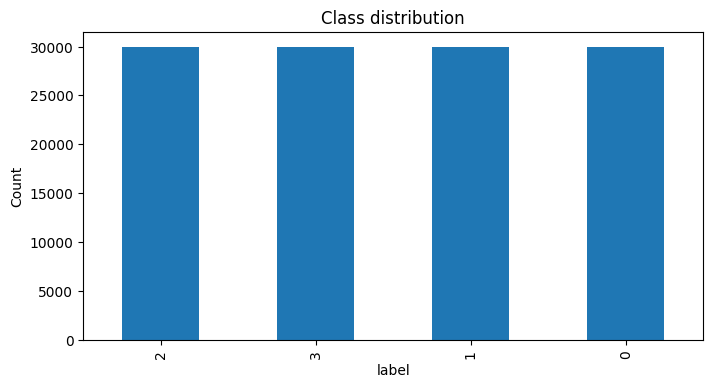

In [7]:
# Cell 5 - Basic EDA: class distribution plot
counts = df['label'].value_counts()
plt.figure(figsize=(8,4))
counts.plot(kind='bar')
plt.title("Class distribution")
plt.ylabel("Count")
plt.show()


In [8]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [9]:
# Text preprocessing function (tokenize, remove stopwords, lemmatize)
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text, lower=True, remove_stopwords=True, lemmatize=True):
    if pd.isna(text):
        return ""
    if lower:
        text = text.lower()
    tokens = word_tokenize(text)
    cleaned = []
    for t in tokens:
        # keep alphabetic tokens only
        if not t.isalpha():
            continue
        if remove_stopwords and t in stop_words:
            continue
        if lemmatize:
            t = lemmatizer.lemmatize(t)
        cleaned.append(t)
    return " ".join(cleaned)

# Apply (this may take a bit of time)
df['text_clean'] = df['text'].astype(str).apply(preprocess_text)
df[['text','text_clean']].head()


,text,text_clean
0,Wall St. Bears Claw Back Into the Black (Reute...,wall bear claw back black reuters reuters wall...
1,Carlyle Looks Toward Commercial Aerospace (Reu...,carlyle look toward commercial aerospace reute...
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,oil economy cloud stock outlook reuters reuter...
3,Iraq Halts Oil Exports from Main Southern Pipe...,iraq halt oil export main southern pipeline re...
4,"Oil prices soar to all-time record, posing new...",oil price soar record posing new menace u econ...


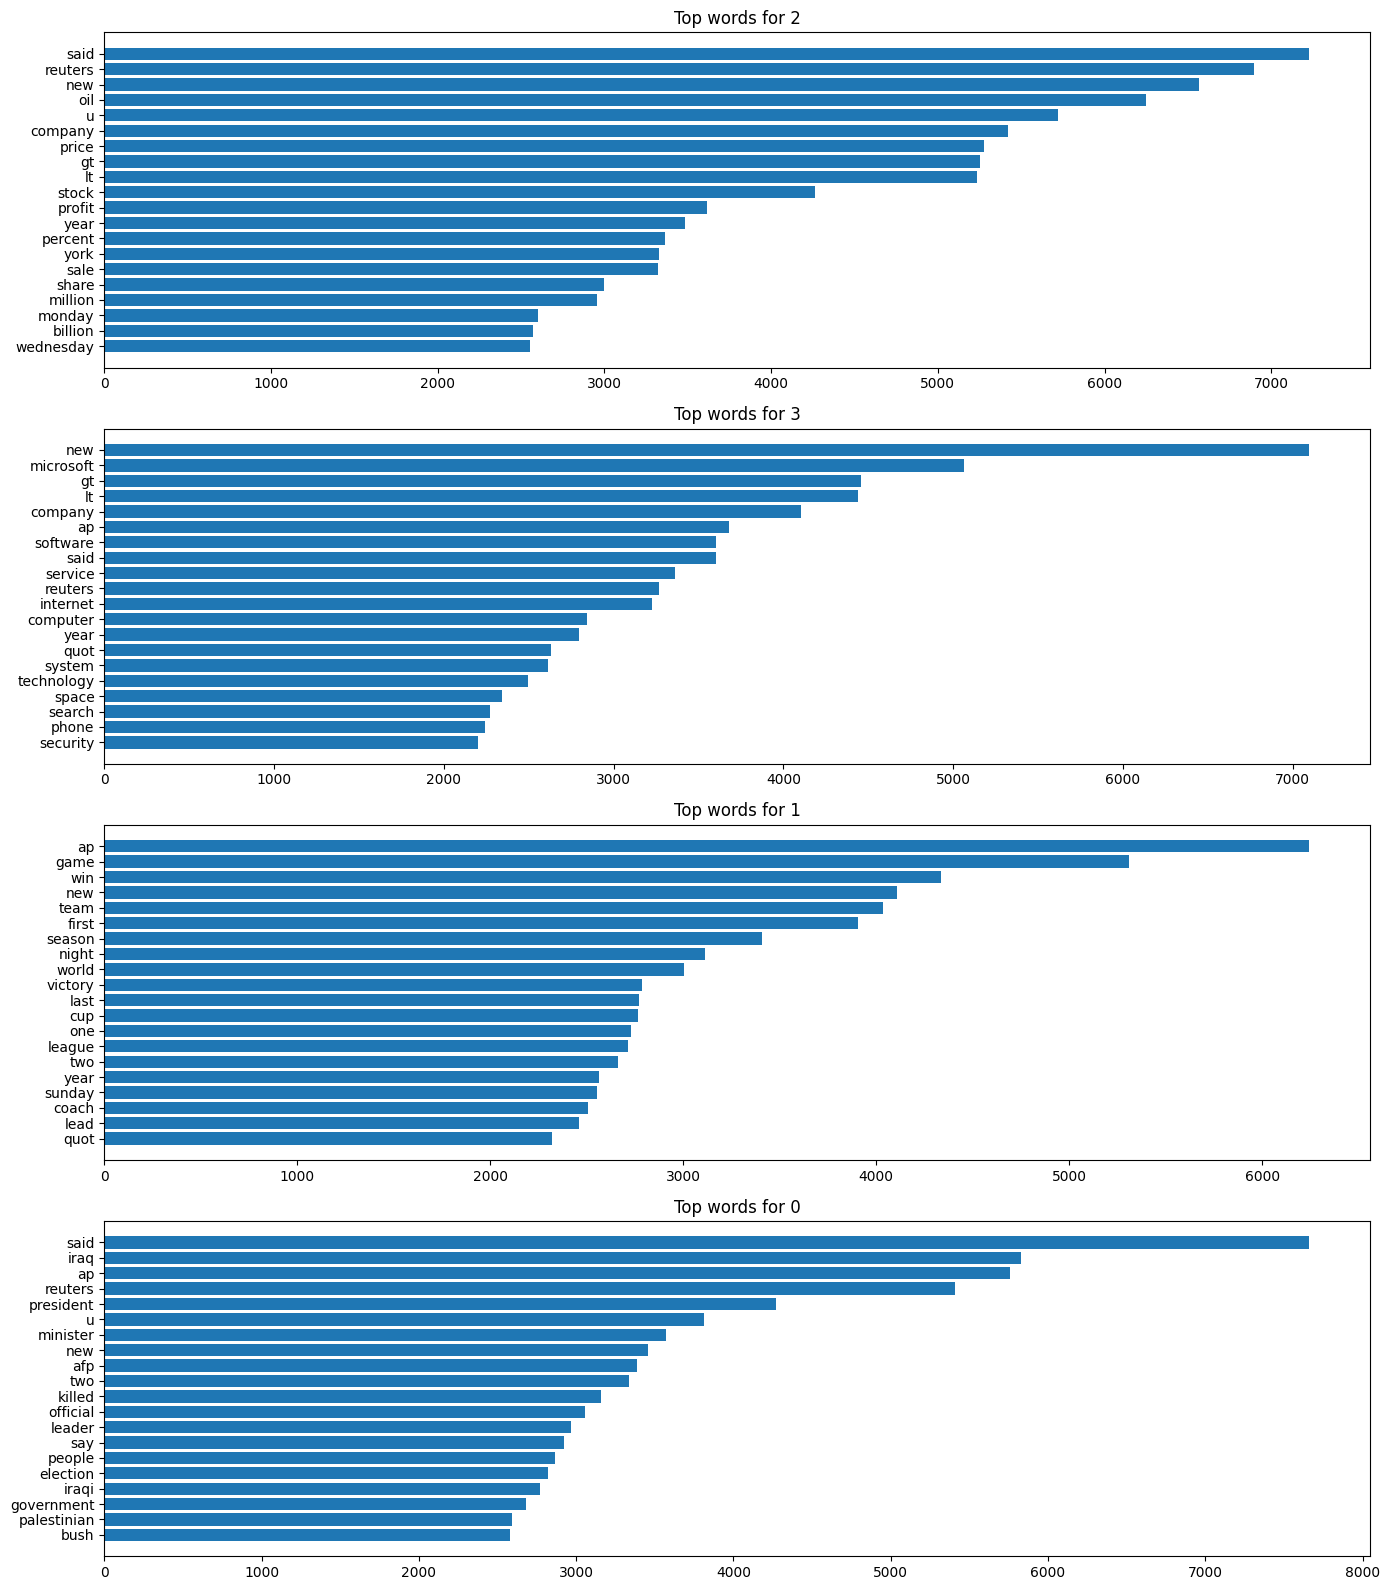

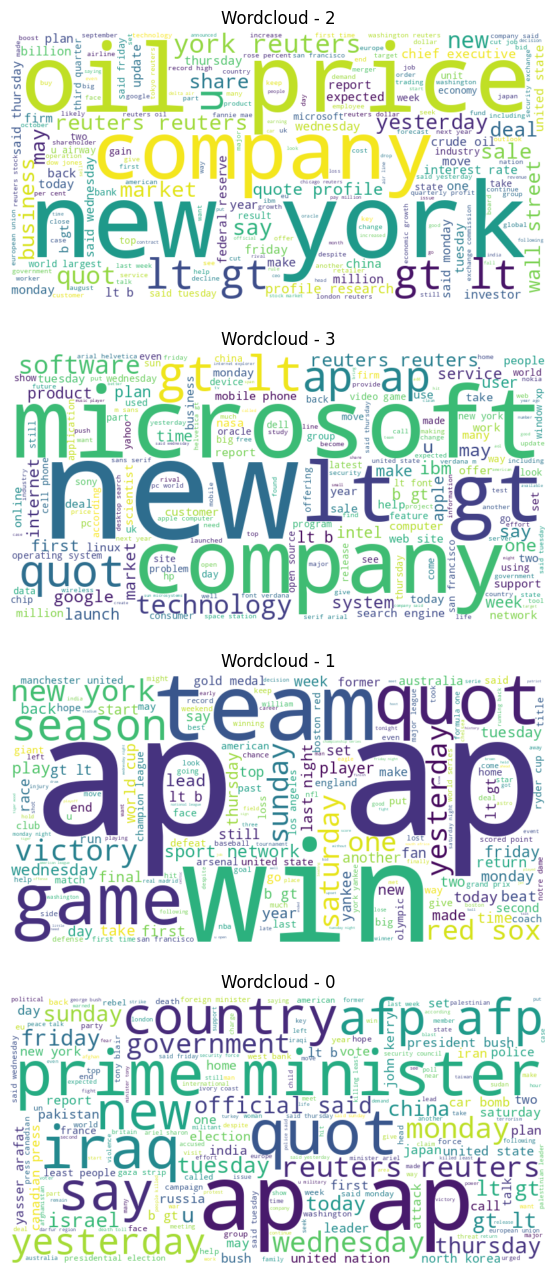

In [10]:
# Visualize most frequent words per class (bar plots) + wordclouds
def top_n_words(series, n=20):
    c = Counter()
    for doc in series:
        c.update(doc.split())
    return c.most_common(n)

labels = df['label'].unique()
plt.figure(figsize=(14, 4*len(labels)))
for i, lbl in enumerate(labels):
    top = top_n_words(df.loc[df['label']==lbl, 'text_clean'], n=20)
    words, freqs = zip(*top) if top else ([],[])
    ax = plt.subplot(len(labels),1,i+1)
    ax.barh(words[::-1], freqs[::-1])
    ax.set_title(f"Top words for {lbl}")
    plt.tight_layout()
plt.show()

# Wordclouds
plt.figure(figsize=(14, 4*len(labels)))
for i, lbl in enumerate(labels):
    text_blob = " ".join(df.loc[df['label']==lbl, 'text_clean'].values)
    wc = WordCloud(width=800, height=400, background_color='white').generate(text_blob)
    ax = plt.subplot(len(labels),1,i+1)
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f"Wordcloud - {lbl}")
plt.show()


In [11]:
#Prepare data for modeling: TF-IDF + train/test split
X = df['text_clean'].values
y = df['label'].values
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=RSEED)

tfidf = TfidfVectorizer(max_features=30000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF shape:", X_train_tfidf.shape)


TF-IDF shape: (96000, 30000)


In [12]:
def evaluate_model(clf, Xtr, Xte, ytr, yte, name="Model"):
    clf.fit(Xtr, ytr)
    ypred = clf.predict(Xte)
    acc = accuracy_score(yte, ypred)
    print(f"=== {name} ===")
    print("Accuracy:", acc)
    print("Classification report:")
    print(classification_report(yte, ypred, target_names=[str(c) for c in le.classes_]))
    cm = confusion_matrix(yte, ypred)
    print("Confusion matrix:\n", cm)
    return clf, acc, cm


In [13]:
# Logistic Regression
lr = LogisticRegression(max_iter=2000, random_state=RSEED, n_jobs=-1)
lr_model, lr_acc, lr_cm = evaluate_model(lr, X_train_tfidf, X_test_tfidf, y_train, y_test, name="Logistic Regression")


=== Logistic Regression ===
Accuracy: 0.9205416666666667
Classification report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      6000
           1       0.96      0.98      0.97      6000
           2       0.89      0.89      0.89      6000
           3       0.90      0.90      0.90      6000

    accuracy                           0.92     24000
   macro avg       0.92      0.92      0.92     24000
weighted avg       0.92      0.92      0.92     24000

Confusion matrix:
 [[5439  179  237  145]
 [  62 5885   29   24]
 [ 173   45 5363  419]
 [ 167   51  376 5406]]


In [14]:
# Random Forest (may be slower)
rf = RandomForestClassifier(n_estimators=200, random_state=RSEED, n_jobs=-1)
rf_model, rf_acc, rf_cm = evaluate_model(rf, X_train_tfidf, X_test_tfidf, y_train, y_test, name="Random Forest")


=== Random Forest ===
Accuracy: 0.8928333333333334
Classification report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      6000
           1       0.92      0.97      0.94      6000
           2       0.86      0.87      0.86      6000
           3       0.87      0.85      0.86      6000

    accuracy                           0.89     24000
   macro avg       0.89      0.89      0.89     24000
weighted avg       0.89      0.89      0.89     24000

Confusion matrix:
 [[5344  232  254  170]
 [  75 5801   61   63]
 [ 186  100 5202  512]
 [ 261  146  512 5081]]


In [15]:
# # SVM
# svm = SVC(kernel='linear', probability=True, random_state=RSEED)
# svm_model, svm_acc, svm_cm = evaluate_model(svm, X_train_tfidf, X_test_tfidf, y_train, y_test, name="SVM (linear)")


In [16]:
# XGBoost (if available)
if has_xgb:
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=RSEED, n_jobs=4)
    xgb_model, xgb_acc, xgb_cm = evaluate_model(xgb, X_train_tfidf, X_test_tfidf, y_train, y_test, name="XGBoost")
else:
    print("XGBoost not installed or import failed; skipping.")


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:57:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== XGBoost ===
Accuracy: 0.8891666666666667
Classification report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      6000
           1       0.92      0.95      0.94      6000
           2       0.86      0.87      0.87      6000
           3       0.86      0.86      0.86      6000

    accuracy                           0.89     24000
   macro avg       0.89      0.89      0.89     24000
weighted avg       0.89      0.89      0.89     24000

Confusion matrix:
 [[5274  241  254  231]
 [  95 5713   87  105]
 [ 193   89 5210  508]
 [ 228  136  493 5143]]


In [17]:
# LightGBM (if available)
if has_lgb:
    lgbm = lgb.LGBMClassifier(random_state=RSEED, n_jobs=-1)
    lgbm_model, lgbm_acc, lgbm_cm = evaluate_model(lgbm, X_train_tfidf, X_test_tfidf, y_train, y_test, name="LightGBM")
else:
    print("LightGBM not installed or import failed; skipping.")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 22.658126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 586401
[LightGBM] [Info] Number of data points in the train set: 96000, number of used features: 15983
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


=== LightGBM ===
Accuracy: 0.8976666666666666
Classification report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.90      6000
           1       0.94      0.96      0.95      6000
           2       0.87      0.87      0.87      6000
           3       0.87      0.86      0.87      6000

    accuracy                           0.90     24000
   macro avg       0.90      0.90      0.90     24000
weighted avg       0.90      0.90      0.90     24000

Confusion matrix:
 [[5358  208  233  201]
 [  87 5768   76   69]
 [ 191   65 5239  505]
 [ 215  112  494 5179]]


In [20]:
# Save best classical model (choose by accuracy; here we compare recorded accs)
results = {
    "LogisticRegression": lr_acc,
    "RandomForest": rf_acc,
}
if has_xgb: results["XGBoost"] = xgb_acc
if has_lgb: results["LightGBM"] = lgbm_acc

best_name = max(results, key=results.get)
print("Classical model accuracies:", results)
print("Best classical model:", best_name)
# Map to object and save
best_model_obj = {"LogisticRegression": lr_model, "RandomForest": rf_model}
if has_xgb: best_model_obj["XGBoost"] = xgb_model
if has_lgb: best_model_obj["LightGBM"] = lgbm_model

import joblib
joblib.dump(best_model_obj[best_name], f"best_classical_{best_name}.joblib")
joblib.dump(tfidf, "tfidf_vectorizer.joblib")
print("Saved:", f"best_classical_{best_name}.joblib", "and tfidf_vectorizer.joblib")


Classical model accuracies: {'LogisticRegression': 0.9205416666666667, 'RandomForest': 0.8928333333333334, 'XGBoost': 0.8891666666666667, 'LightGBM': 0.8976666666666666}
Best classical model: LogisticRegression
Saved: best_classical_LogisticRegression.joblib and tfidf_vectorizer.joblib


In [ ]:
# Keras feedforward NN on TF-IDF inputs
# Convert sparse to dense (if memory allows). If very large, use a smaller max_features earlier.
Xtr_dense = X_train_tfidf.toarray()
Xte_dense = X_test_tfidf.toarray()
num_classes = len(le.classes_)
input_dim = Xtr_dense.shape[1]

model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

es = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(Xtr_dense, y_train,
                    validation_split=0.1,
                    epochs=20,
                    batch_size=128,
                    callbacks=[es], verbose=2)

# Evaluate
loss, acc = model.evaluate(Xte_dense, y_test, verbose=0)
print("Keras FFNN test accuracy:", acc)
# Save
model.save("keras_tfidf_ffnn.h5")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │    15,360,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,492,868 (59.10 MB)

 Trainable params: 15,492,868 (59.10 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# (Optional) Keras Tokenizer + Embedding + LSTM model
# This model uses a learned embedding (no pretrained GloVe). Might help if you want sequential model.
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 30000
max_len = 200

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

Xtr_seq = pad_sequences(sequences_train, maxlen=max_len, padding='post', truncating='post')
Xte_seq = pad_sequences(sequences_test, maxlen=max_len, padding='post', truncating='post')

embedding_dim = 100
model_seq = models.Sequential([
    layers.Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    layers.Bidirectional(layers.LSTM(64, return_sequences=False)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
model_seq.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_seq.summary()
es2 = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
hist_seq = model_seq.fit(Xtr_seq, y_train, validation_split=0.1, epochs=10, batch_size=128, callbacks=[es2], verbose=2)

loss_seq, acc_seq = model_seq.evaluate(Xte_seq, y_test, verbose=0)
print("Keras Embedding+LSTM test accuracy:", acc_seq)
model_seq.save("keras_embedding_lstm.h5")


In [ ]:
# Utility: show confusion matrix heatmap for best model (example uses lr_model)
import seaborn as sns
best = lr_model  # change to best_classical if you want
ypred_best = best.predict(X_test_tfidf)
cm = confusion_matrix(y_test, ypred_best)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Best Classical Model')
plt.show()


In [ ]:
# Inference utility: function to predict on raw text
def predict_text(raw_text, model=best_model_obj[best_name], tfidf_vec=tfidf):
    txt_clean = preprocess_text(raw_text)
    vect = tfidf_vec.transform([txt_clean])
    pred_idx = model.predict(vect)
    if hasattr(pred_idx, "__len__") and len(pred_idx.shape)==2: # probability vector possibly
        pred_label = np.argmax(pred_idx, axis=1)[0]
    else:
        pred_label = pred_idx[0]
    return le.inverse_transform([int(pred_label)])[0]

# Example
print(predict_text("Apple releases new iPhone with advanced AI features."))
print(predict_text("The team won the championship in a thrilling final game."))
